In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, BitsAndBytesConfig, pipeline
from transformers.pipelines.pt_utils import KeyDataset
from peft import PeftModel, PeftConfig
from dotenv import dotenv_values
import torch
from tqdm.auto import tqdm
import evaluate

from utils import DataPreprocessor, DatasetFormatConverter
from utils import DataPreprocessor

from src.billm import LlamaForTokenClassification

WANDB_KEY = dotenv_values(".env.base")['WANDB_KEY']
LLAMA_TOKEN = dotenv_values(".env.base")['LLAMA_TOKEN']
HF_TOKEN = dotenv_values(".env.base")['HF_TOKEN']

adapters = "ferrazzipietro/LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_64_64_0.05_8_0.0002"
peft_config = PeftConfig.from_pretrained(adapters)
BASE_MODEL_CHECKPOINT = peft_config.base_model_name_or_path

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_CHECKPOINT,token =HF_TOKEN)
tokenizer.pad_token = tokenizer.eos_token
# seqeval = evaluate.load("seqeval")
DATASET_CHEKPOINT="ferrazzipietro/e3c-sentences" 
TRAIN_LAYER="en.layer1"
preprocessor = DataPreprocessor(BASE_MODEL_CHECKPOINT, 
                                tokenizer)
dataset = load_dataset(DATASET_CHEKPOINT) #download_mode="force_redownload"
dataset = dataset[TRAIN_LAYER]
dataset = dataset.shuffle(seed=1234)  
dataset_format_converter = DatasetFormatConverter(dataset)
dataset_format_converter.apply()
ds = dataset_format_converter.dataset
label2id = dataset_format_converter.label2id
id2label = dataset_format_converter.get_id2label()
label_list = dataset_format_converter.get_label_list()
dataset_format_converter.set_tokenizer(tokenizer)
dataset_format_converter.set_max_seq_length(256)
tokenized_ds = ds.map(lambda x: dataset_format_converter.tokenize_and_align_labels(x), batched=True)# dataset_format_converter.dataset.map(tokenize_and_align_labels, batched=True)
train_data, val_data, test_data = preprocessor.split_layer_into_train_val_test_(tokenized_ds, TRAIN_LAYER)


/home/pferrazzi/LS-LLaMA-E3C/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


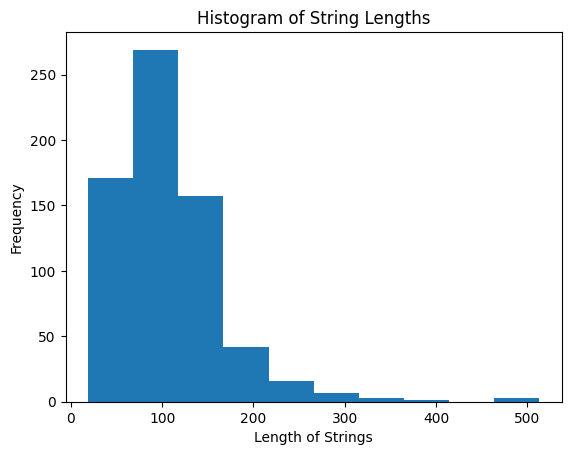

In [3]:
import matplotlib.pyplot as plt

# Get the lengths of the strings
lengths = [len(sentence) for sentence in train_data['sentence']]

# Plot the histogram
plt.hist(lengths, bins=10)
plt.xlabel('Length of Strings')
plt.ylabel('Frequency')
plt.title('Histogram of String Lengths')
plt.show()

In [5]:
bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.bfloat16,
                )

model = LlamaForTokenClassification.from_pretrained(
    peft_config.base_model_name_or_path,
    num_labels=len(label2id), id2label=id2label, label2id=label2id,
    token = HF_TOKEN,
    cache_dir='/data/disk1/share/pferrazzi/.cache',
    device_map='auto',
    quantization_config = bnb_config)
model = PeftModel.from_pretrained(model, adapters, token = HF_TOKEN)
model = model.merge_and_unload()

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
Some weights of LlamaForTokenClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.
/home/pferrazzi/LS-LLaMA-E3C/.venv/lib/python3.11/site-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [ ]:

seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    print(results)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [11]:
class OutputGeneration():
    def __init__(self, model, tokenizer, label2id):
        self.model = model
        self.tokenizer = tokenizer
        self.label2id = label2id
    
    def _create_prediction_list(self, model_output):
        model_output_logits = model_output.logits.cpu().detach().float().numpy()
        preds = np.argmax(model_output_logits, axis=2)
        preds_list = []
        for pred in preds:
            preds_list.append([self.label2id[label] for label in pred])
        return preds_list

    def _generate_batch(self, input_sentences, model, tokenizer):
        encodeds = tokenizer(input_sentences, return_tensors="pt", add_special_tokens=True, padding=True)
        model_inputs = encodeds.to('cuda')
        generated_ids = model(**model_inputs)
        preds = self._create_prediction_list(generated_ids)
        return preds
    

    def add_output_column(self, data, model, tokenizer, batch_size:int) -> None:
        """
        Adds a column with the response of the model to the actual query.
        
        params:
        model: the model to use to generate the response
        tokenizer: the tokenizer to use to generate the response
        batch_size: the batch size to use to process the examples. Increasing this makes it faster but requires more GPU. Default is 8.
        """
        responses_col = []
        total_rows = len(data)
        indexes = [i for i in range(len(data)) if i % batch_size == 0]
        max_index = data.shape[0]

        with tqdm(total=total_rows, desc="generating responses") as pbar:
            for i, idx in enumerate(indexes[:-1]):
                indici = list(range(idx, indexes[i+1]))
                tmp = self._generate_batch(data.select(indici)['sentence'], model, tokenizer)
                responses_col.extend(tmp)
                pbar.update(batch_size)
            indici = list(range(indexes[len(indexes[:-1])], max_index))
            tmp = self._generate_batch(data.select(indici)['sentence'], model, tokenizer)
            responses_col.extend(tmp)
            pbar.update(batch_size)
        
        data = data.add_column('model_responses', responses_col)
        return data
   
output_generation = OutputGeneration(model, tokenizer, id2label)
tmp = output_generation.add_output_column(train_data.select(range(6)), model, tokenizer, 3) 



generating responses: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


In [29]:
examples = [train_data['sentence'][0] , train_data['sentence'][5]]
input_sentences = examples
encodeds = tokenizer(input_sentences, return_tensors="pt", add_special_tokens=True, padding=True)
model_inputs = encodeds.to('cuda')
generated_ids = model(**model_inputs)

#gen = OutputGeneration(model, tokenizer, id2label)
#pl = gen._create_prediction_list(generated_ids)

TokenClassifierOutput(loss={'logits': tensor([[[ 5.6104e-01, -3.7344e+00, -5.5957e-01],
         [ 6.6797e-01, -1.0869e+00, -2.2871e+00],
         [-2.3242e+00, -2.1172e+00,  1.1387e+00],
         [ 2.2754e+00,  1.2021e+00, -1.8037e+00],
         [ 6.5869e-01,  1.9824e+00, -2.8145e+00],
         [ 2.4980e+00,  3.2275e-01, -3.0859e+00],
         [ 1.8848e+00, -1.2773e+00, -3.1465e+00],
         [ 1.1963e+00, -3.0713e-01, -9.5654e-01],
         [ 3.3926e+00, -1.6904e+00, -1.4746e+00],
         [ 1.3389e+00,  5.6689e-01,  1.6436e+00],
         [ 1.0381e+00, -7.4316e-01, -5.7678e-02],
         [ 1.0088e+00,  2.6099e-01, -8.0713e-01],
         [ 1.1246e-02, -1.0391e+00,  4.9048e-01],
         [-3.0054e-01, -4.4414e+00, -2.6831e-01],
         [-8.7500e-01,  3.0000e+00, -1.0010e+00],
         [-9.9658e-01,  2.9434e+00, -1.0312e+00],
         [-1.0449e+00,  2.9062e+00, -1.1006e+00],
         [-1.0439e+00,  2.9473e+00, -1.0967e+00],
         [-1.0664e+00,  2.9902e+00, -1.0869e+00],
         [-1

In [31]:
generated_ids.logits[0]

tensor([[ 0.5610, -3.7344, -0.5596],
        [ 0.6680, -1.0869, -2.2871],
        [-2.3242, -2.1172,  1.1387],
        [ 2.2754,  1.2021, -1.8037],
        [ 0.6587,  1.9824, -2.8145],
        [ 2.4980,  0.3228, -3.0859],
        [ 1.8848, -1.2773, -3.1465],
        [ 1.1963, -0.3071, -0.9565],
        [ 3.3926, -1.6904, -1.4746],
        [ 1.3389,  0.5669,  1.6436],
        [ 1.0381, -0.7432, -0.0577],
        [ 1.0088,  0.2610, -0.8071],
        [ 0.0112, -1.0391,  0.4905],
        [-0.3005, -4.4414, -0.2683],
        [-0.8750,  3.0000, -1.0010],
        [-0.9966,  2.9434, -1.0312],
        [-1.0449,  2.9062, -1.1006],
        [-1.0439,  2.9473, -1.0967],
        [-1.0664,  2.9902, -1.0869],
        [-1.0947,  3.0039, -1.0439],
        [-1.1230,  2.9941, -1.0244],
        [-1.1230,  2.9629, -1.0596],
        [-1.1006,  2.9355, -1.1035],
        [-1.0820,  2.9238, -1.1416],
        [-1.1025,  2.9941, -1.1328],
        [-1.1318,  3.0547, -1.0879],
        [-1.1777,  3.1250, -1.0508],
 

In [28]:
for i, s in enumerate([0,5]):
    print((train_data[s]['sentence']))
    print(f"n words in sentence: {len(train_data[s]['sentence'].split())}")
    print(f"len_ sentence: {len(train_data[s]['sentence'])}")
    print(f"n tokens with labels: {len(train_data[s]['labels'])}")
    print(f"n  created labels: {len(generated_ids['logits'][i])}")

Their child acquired walking at the age of 14 months.
n words in sentence: 10
len_ sentence: 53
n tokens with labels: 14
n  created labels: 78
Pertinent laboratory studies included a hemoglobin level of 10 g/dL, platelet count was normal, blood urea of 1,2 g/l (0,18-0,45 g/L), and a creatinine level of 68 mg/L (7-13 mg/L).
n words in sentence: 30
len_ sentence: 181
n tokens with labels: 78
n  created labels: 78


In [25]:
import pandas as pd


token_classifier = pipeline("token-classification", model=model, 
                            tokenizer=tokenizer, 
                            aggregation_strategy="simple", batch_size=12)
token_classifier(train_data[0]['sentence'])
l = []
for out in tqdm(token_classifier(KeyDataset(train_data.select(range(24)), "sentence"))):
    l.append(out)

tmp = train_data.select(range(24)).add_column('model_output', l)
tmp[6]['model_output']

The model 'LlamaForTokenClassification' is not supported for token-classification. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GPT2ForTokenClassification', 'GPT2ForTokenClassification', 'GPTBigCodeForTokenClassification', 'GPTNeoForTokenClassification', 'GPTNeoXForTokenClassification', 'IBertForTokenClassification', 'LayoutLMForTokenCl

RuntimeError: The expanded size of the tensor (14) must match the existing size (4096) at non-singleton dimension 2.  Target sizes: [1, 32, 14, 14].  Tensor sizes: [1, 1, 4096, 14]

In [20]:
print(train_data[0]['tokens'])
example = train_data[0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['Their', 'child', 'acquired', 'walking', 'at', 'the', 'age', 'of', '14', 'months.']


['<s>',
 '▁Their',
 '▁child',
 '▁acquired',
 '▁walking',
 '▁at',
 '▁the',
 '▁age',
 '▁of',
 '▁',
 '1',
 '4',
 '▁months',
 '.']

In [32]:
import pandas as pd


token_classifier = pipeline("ner", model=model, 
                            tokenizer=tokenizer, 
                            aggregation_strategy="simple", batch_size=12)


#token_classifier(train_data[0]['tokens'])
l = []
for out in tqdm(token_classifier(KeyDataset(train_data.select(range(24)), "sentence"))):
    l.append(out)

tmp = train_data.select(range(24)).add_column('model_output', l)
tmp[6]['model_output']

The model 'LlamaForTokenClassification' is not supported for ner. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GPT2ForTokenClassification', 'GPT2ForTokenClassification', 'GPTBigCodeForTokenClassification', 'GPTNeoForTokenClassification', 'GPTNeoXForTokenClassification', 'IBertForTokenClassification', 'LayoutLMForTokenClassification', 'L

[{'end': 24,
  'entity_group': 'B',
  'score': 0.657,
  'start': 7,
  'word': 'assessment found'},
 {'end': 38,
  'entity_group': 'B',
  'score': 0.794,
  'start': 32,
  'word': 'score'},
 {'end': 44,
  'entity_group': 'B',
  'score': 0.6616,
  'start': 40,
  'word': 'GCS)'},
 {'end': 48, 'entity_group': 'B', 'score': 0.6094, 'start': 47, 'word': ''},
 {'end': 52, 'entity_group': 'I', 'score': 0.585, 'start': 51, 'word': '1'},
 {'end': 53, 'entity_group': 'B', 'score': 0.572, 'start': 52, 'word': '5'},
 {'end': 66,
  'entity_group': 'B',
  'score': 0.824,
  'start': 55,
  'word': 'eye opening'},
 {'end': 70, 'entity_group': 'B', 'score': 0.708, 'start': 69, 'word': ''},
 {'end': 72, 'entity_group': 'B', 'score': 0.4004, 'start': 71, 'word': ','},
 {'end': 88,
  'entity_group': 'B',
  'score': 0.628,
  'start': 76,
  'word': 'bal response'},
 {'end': 93, 'entity_group': 'B', 'score': 0.6816, 'start': 91, 'word': '2'},
 {'end': 100,
  'entity_group': 'I',
  'score': 0.623,
  'start': 94,

In [18]:
import pandas as pd
import ast
import evaluate
seqeval = evaluate.load("seqeval")
data = load_dataset("csv", data_files="data/evaluation/train_data_LS_Mistral-7B-v0.1_adapters_en.layer1_NoQuant_16_32_0.01_2_0.0002.csv")
def helper(example):
    example['model_output'] = ast.literal_eval(example['model_output'].replace('\n', ','))
    return example
data = data.map(lambda x: helper(x))

def compute_metrics(logits, labels):
    model_output_logits = logits.cpu().detach().float().numpy()    
    predictions = np.argmax(model_output_logits, axis=1)
    print(predictions)
    print(type(predictions))
    print(type(labels))
    lista = []
    for i in range(len(labels)):
        print('pred: ', predictions[i], 'label: ', labels[i])
        if labels[i] != -100:
         lista.append(label_list[predictions[i]])
    print('lista: ', lista)

    print( [label_list[prediction] for i, prediction in enumerate(predictions) if labels[i] != -100 ] )

    
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["soverall_f1"],
        "accuracy": results["overall_accuracy"],
    }


In [109]:
label_list

['O', 'B', 'I']

In [76]:
def _create_prediction_list(self, model_output):
        model_output_logits = model_output.logits.cpu().detach().float().numpy()
        preds = np.argmax(model_output_logits, axis=2)
        preds_list = []
        for pred in preds:
            preds_list.append([self.id2label[label] for label in pred])
        return preds_list


[['B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'B',
  'I',
  'O',
  'I',
  'B',
  'B',
  'O',
  'O',
  'B',
  'O',
  'O',
  'B',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'B',
  'O',
  'O',
  'O',
  'B',
  'B',
  'O',
  'O',
  'B',
  'O',
  'B',
  'O',
  'O',
  'I',
  'O',
  'B',
  'O',
  'O',
  'O',
  'B',
  'B',
  'O',
  'B',
  'B',
  'O',
  'O',
  'I',
  'O',
  'O',
  'B',
  'B',
  'O',
  'B',
  'O',
  'B',
  'O',
  'B',
  'B',
  'O',
  'I',
  'I',
  'B',
  'B',
  'O',
  'I',
  'I',
  'O',
  'B',
  'O',
  'O',
  'O',
  'O',
  'B',
  'B',
  'B',
  'O',
  'B',
  'B',
  'I',
  'I',
  'O',
  'B',
  'O'

In [112]:
generated_ids['logits'][0]
print(type(label_list))

<class 'list'>


In [24]:
print(len(train_data[0]['labels']))
print(len(train_data[0]['sentence']))
print(len(generated_ids['logits'][0]))

166
53
76


In [29]:
examples = train_data.select(range(2))
examples

Dataset({
    features: ['sentence', 'entities', 'original_text', 'original_id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2
})

In [55]:
print((examples[0]['ner_tags']))
print(len(examples[0]['sentence']))
print((examples[0]['sentence']))
print((examples[0]['labels']))
#print(len(examples['logits'][0]))
print(labels[0])
label2id

[1, 2, 1, 1, 0, 0, 0, 0, 0, 0]
53
Their child acquired walking at the age of 14 months.
[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,

{'O': 0, 'B': 1, 'I': 2}

In [120]:
dataset = load_dataset(DATASET_CHEKPOINT) #download_mode="force_redownload"
dataset = dataset[TRAIN_LAYER]
dataset = dataset.shuffle(seed=1234)  
dataset_format_converter = DatasetFormatConverter(dataset)
dataset_format_converter.apply()
ds = dataset_format_converter.dataset
label2id = dataset_format_converter.label2id
id2label = dataset_format_converter.get_id2label()
label_list = dataset_format_converter.get_label_list()
dataset = ds.map(lambda x: tokenize_and_align_labels(x), batched = True)

Map: 100%|██████████| 1520/1520 [00:00<00:00, 13777.85 examples/s]


In [126]:
train_data, val_data, test_data = preprocessor.split_layer_into_train_val_test_(dataset, TRAIN_LAYER)
for i in range(8):
    print('sentece: ', train_data[i]['sentence'], '\nlabels: ', train_data[i]['labels'])

sentece:  Their child acquired walking at the age of 14 months. 
labels:  [-100, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sentece:  An abdominal ultrasound examination was reported as normal. 
labels:  [-100, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 2]
sentece:  Her blood pressure was 100/70 mmHg with a pulse rate of 98 beats/min, respiratory rate about 16/min and oral temperature of 37°C. 
labels:  [-100, 0, 1, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 0, 1, 2, 2, 2, 2, 0, 0, 1, 0, 1, 2, 2, 2, 2, 2]
sentece:  Emergency neck computed tomography angiography showed a contrast-enhanced abscess cavity posterior to the left retropharyngeal space, and a low-density area surrounded by an area without contrast enhancement in the posterior neck. 
labels:  [-100, 0, 0, 1, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2]
sentece:  The mitotic rate was extremely high (1

In [117]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, words_label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        label_ids = []
        for k, word_idx in enumerate(word_ids): 
            same_word_as_previous  = False if (word_idx != word_ids[k-1] or k==0) else True
            if word_idx is None:
                token_label = -100
            elif words_label[word_idx] == label2id['O']:
                token_label = label2id['O']
            elif same_word_as_previous:
                token_label = label2id['I']
            elif not same_word_as_previous:
                token_label = words_label[word_idx]
            label_ids.append(token_label)
            # if word_idx is not None:#  and k>12:
            #     print("word_label: ", words_label[word_idx])
            # print(tokenizer.decode(tokenized_inputs[i].ids[k]), ": ",word_idx,  "\nassigned_token_label:",  label_ids[k], '\n')
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs
tokenize_and_align_labels(ds.select(range(2, 4)))

{'input_ids': [[1, 1094, 534, 2920, 1475, 9271, 12423, 687, 20976, 403, 5745, 390, 4123, 28723], [1, 21127, 277, 4475, 8289, 302, 272, 16594, 28765, 6642, 369, 23096, 8894, 654, 5278, 354, 264, 9194, 302, 1581, 6752, 1716, 404, 325, 5072, 28731, 325, 5072, 28770, 28781, 28725, 8204, 28740, 28774, 28725, 8204, 28740, 28734, 28725, 8204, 28750, 28750, 304, 19966, 5278, 354, 8204, 28781, 28782, 28731, 8735, 288, 334, 7016, 9237, 3000, 678, 628, 305, 1082, 721, 806, 23096, 297, 2088, 434, 352, 28723]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 2], [-100, 0, 1, 2, 2, 0, 1, 2, 2, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1, 2, 0,

In [19]:
# examples = [train_data['sentence'][0] , train_data['sentence'][5]]
# input_sentences = examples
# encodeds = tokenizer(input_sentences, return_tensors="pt", add_special_tokens=True, padding=True)
# model_inputs = encodeds.to('cuda')
# generated_ids = model(**model_inputs)
# model_output_logits = generated_ids.logits.cpu().detach().float().numpy()
examples = [train_data['sentence'][0], train_data['sentence'][5]]
input_sentences = examples
encodeds = tokenizer(input_sentences, return_tensors="pt", add_special_tokens=True, padding=True)
model_inputs = encodeds.to('cuda')
generated_ids = model(**model_inputs)
#gen = OutputGeneration(model, tokenizer, id2label)
#pl = gen._create_prediction_list(generated_ids)
compute_metrics(generated_ids['logits'][0],   train_data[0]['labels'])

sequence_output.shape=torch.Size([2, 76, 4096])
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 1 1 0 0 1 0 0 1 0
 0 0]
<class 'numpy.ndarray'>
<class 'list'>
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 label:  -100
pred:  1 

IndexError: index 76 is out of bounds for axis 0 with size 76

In [81]:
train_data[0]['labels']

[-100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,

In [78]:
train_data[0].keys()

dict_keys(['sentence', 'entities', 'original_text', 'original_id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'])

In [66]:
example = tmp[1]
labels = [label_list[i] for i in example[f"ner_tags"]]
print(labels)
print(example['tokens'])
print(tokenizer(example['sentence']))
print(tokenizer.decode(tokenizer(example['sentence'])['input_ids']))
print(example['model_output'])

['O', 'O', 'O', 'B', 'O', 'B', 'O', 'B']
['An', 'abdominal', 'ultrasound', 'examination', 'was', 'reported', 'as', 'normal.']
{'input_ids': [1, 1094, 534, 2920, 1475, 9271, 12423, 687, 20976, 403, 5745, 390, 4123, 28723], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
<s> An abdominal ultrasound examination was reported as normal.
[{'end': 8, 'entity_group': 'B', 'score': 0.648, 'start': 5, 'word': 'dom'}, {'end': 15, 'entity_group': 'B', 'score': 0.928, 'start': 12, 'word': 'ul'}, {'end': 35, 'entity_group': 'B', 'score': 0.9463, 'start': 23, 'word': 'examination'}, {'end': 48, 'entity_group': 'B', 'score': 0.8286, 'start': 39, 'word': 'reported'}, {'end': 58, 'entity_group': 'B', 'score': 0.6094, 'start': 51, 'word': 'normal'}]
